In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install imblearn
!pip install seaborn

importy pakietów i danych

In [1]:
import cv2
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dane = pd.read_csv('fer2013.csv')

przetwarzanie danych

In [3]:
dane.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
dane['emotion'].shape

(35887,)

In [5]:
emocje = dane['emotion'].value_counts(normalize=True)
emocje

3    0.250481
6    0.172709
4    0.169337
2    0.142698
0    0.138017
5    0.111517
1    0.015242
Name: emotion, dtype: float64

In [6]:
mapowanie_emocji = {0: 'złość', 1: 'obrzydzenie', 2: 'strach', 3: 'radość', 4: 'smutek', 5: 'zaskoczenie', 6: 'obojętność'}
emocje = emocje.rename(index=mapowanie_emocji)
emocje

radość         0.250481
obojętność     0.172709
smutek         0.169337
strach         0.142698
złość          0.138017
zaskoczenie    0.111517
obrzydzenie    0.015242
Name: emotion, dtype: float64

In [7]:
emocje = dane['emotion'].value_counts(normalize=False)
emocje

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

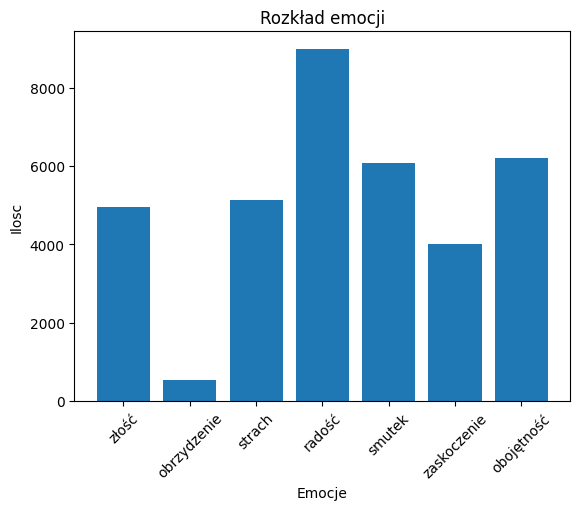

In [8]:
plt.bar(emocje.index, emocje.values)
plt.xlabel('Emocje')
plt.ylabel('Ilosc')
plt.title('Rozkład emocji')
plt.xticks(emocje.index, [mapowanie_emocji[emocja] for emocja in emocje.index], rotation=45)
plt.show()

In [9]:
np.array(dane.iloc[0,1].split(), dtype='uint8').shape # przygotowanie do reshape

(2304,)

In [10]:
np.array(dane.iloc[0,1].split(), dtype='uint8').reshape(48,48)

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]], dtype=uint8)

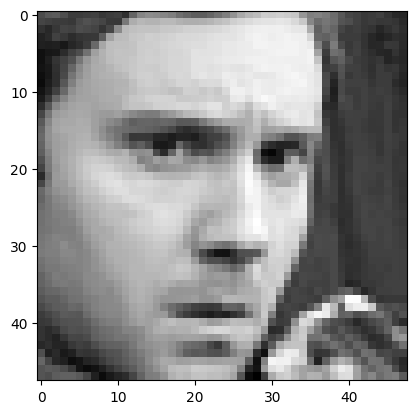

In [11]:
plt.imshow(np.array(dane.iloc[0,1].split(), dtype='uint8').reshape(48,48), cmap='gray') 

0


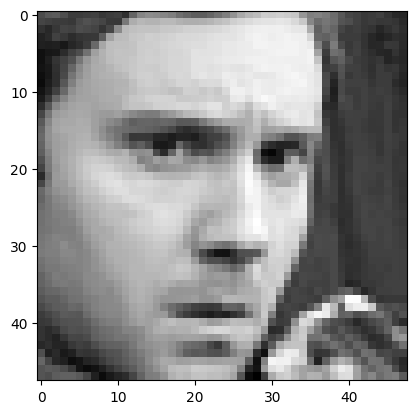

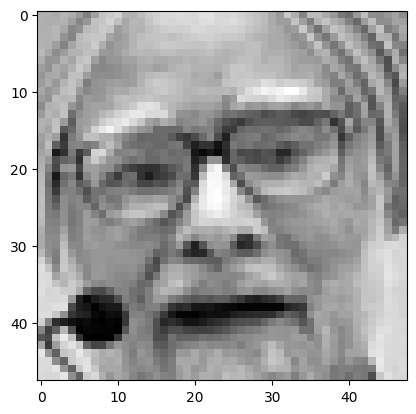

1


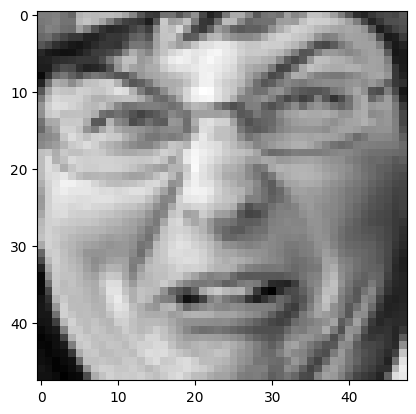

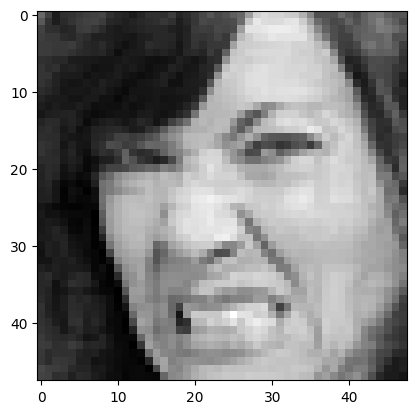

2


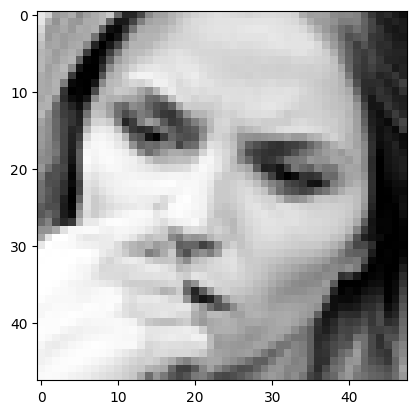

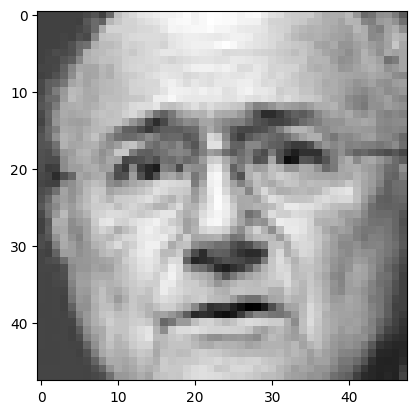

3


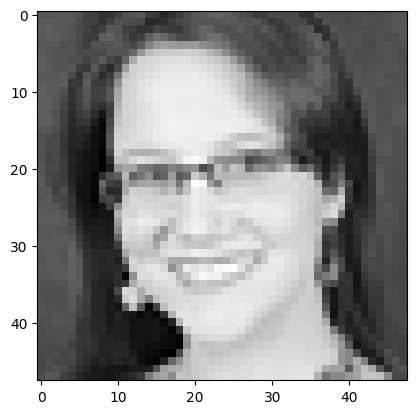

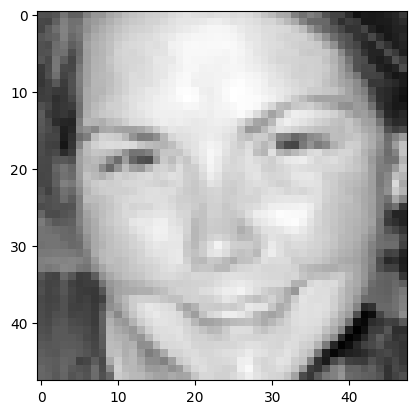

4


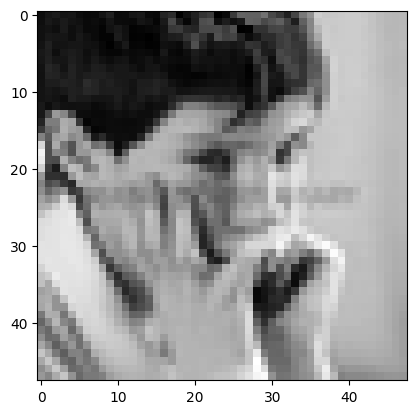

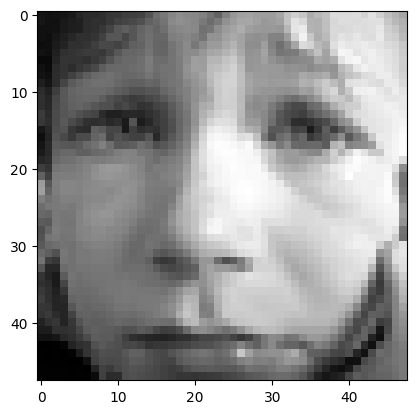

5


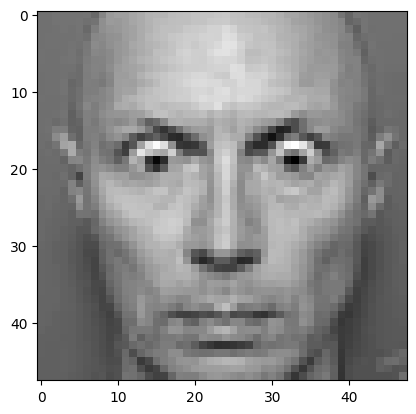

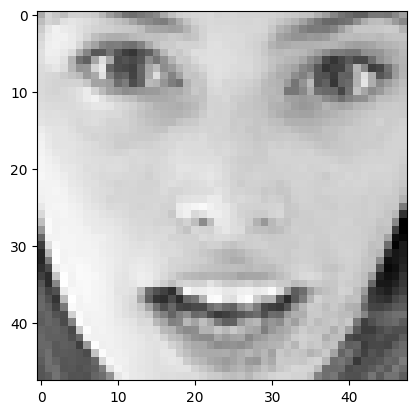

6


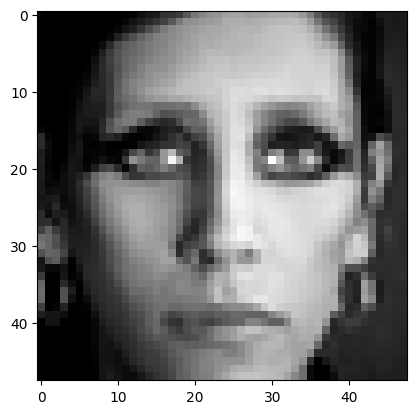

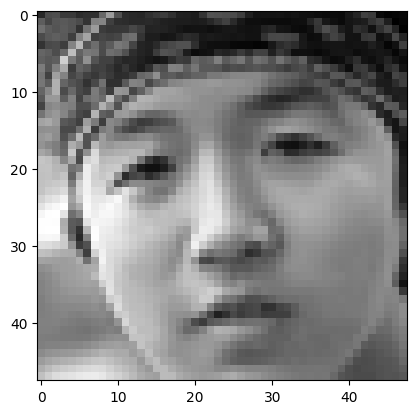

In [12]:
for i in range(7):
    print(i)
    #display(dane.loc[dane['emotion'] == i,:])
    for j in range(2):
        plt.imshow(np.array(dane.loc[dane['emotion'] == i,:].iloc[j,1].split(), dtype='uint8').reshape(48,48), cmap='gray')
        
        #plt.tight_layout()
        plt.show()

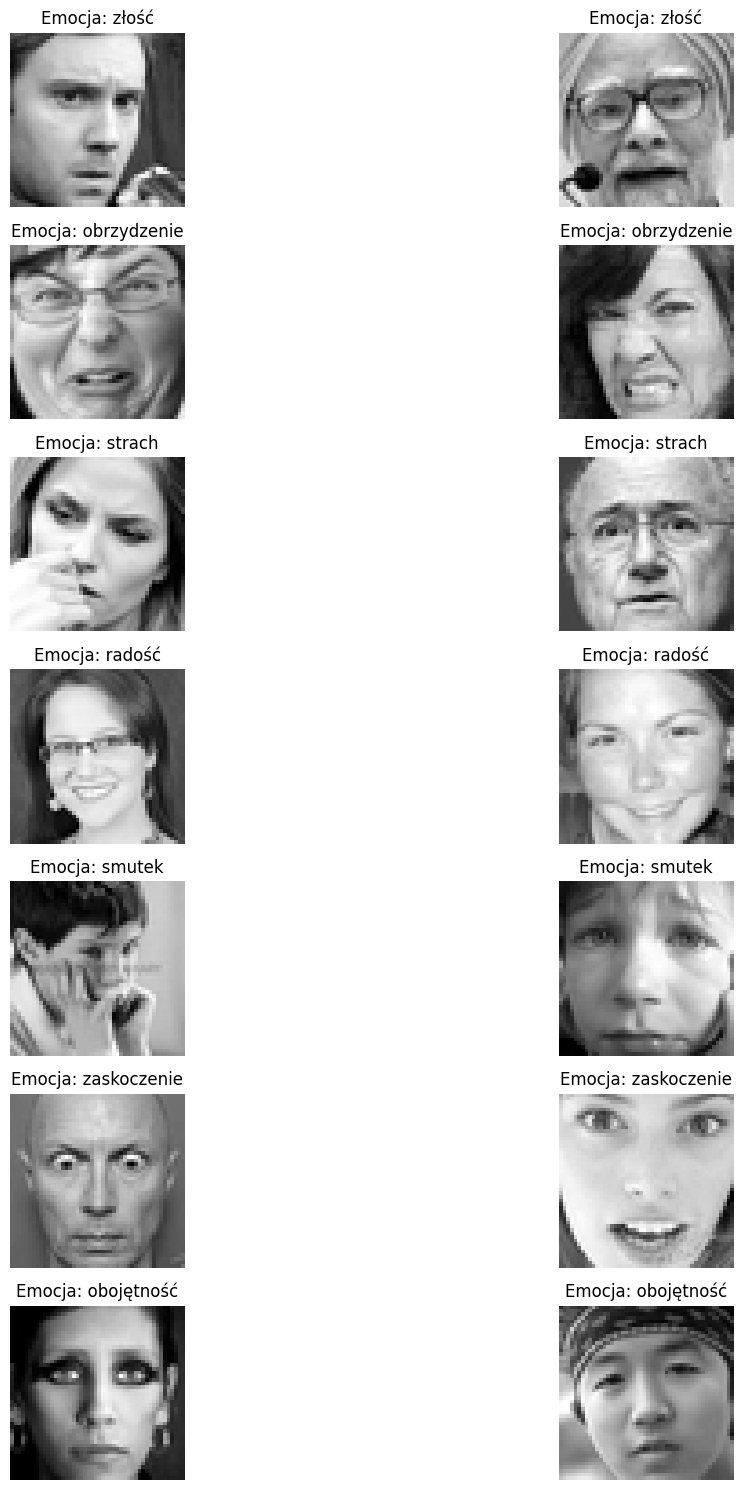

In [13]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))

for i in range(7):
    obrazy = dane[dane['emotion'] == i]['pixels'].values[:2]  
    for j in range(2):
        piksele = np.array(obrazy[j].split(), dtype='uint8').reshape((48, 48))
        axs[i, j].imshow(piksele, cmap='gray')
        axs[i, j].set_title('Emocja: {}'.format(mapowanie_emocji[i]))
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

przygotowanie modelu

In [14]:
label_encoder = LabelEncoder()
dane['emotion'] = label_encoder.fit_transform(dane['emotion'])

In [15]:
X = np.array([np.fromstring(x, dtype=int, sep=' ') for x in dane['pixels']])
y = to_categorical(dane['emotion'], num_classes=7) 

In [16]:
X.shape

(35887, 2304)

In [17]:
y.shape

(35887, 7)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [20]:
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

model sekwencyjny

In [21]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [24]:
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
359/359 [==============================] - 99s 271ms/step - loss: 1.8075 - accuracy: 0.2503 - val_loss: 1.7321 - val_accuracy: 0.2654
Epoch 2/20
359/359 [==============================] - 92s 256ms/step - loss: 1.5819 - accuracy: 0.3755 - val_loss: 1.4565 - val_accuracy: 0.4441
Epoch 3/20
359/359 [==============================] - 82s 228ms/step - loss: 1.3916 - accuracy: 0.4620 - val_loss: 1.3296 - val_accuracy: 0.4953
Epoch 4/20
359/359 [==============================] - 85s 236ms/step - loss: 1.2832 - accuracy: 0.5068 - val_loss: 1.2693 - val_accuracy: 0.5127
Epoch 5/20
359/359 [==============================] - 81s 225ms/step - loss: 1.1975 - accuracy: 0.5419 - val_loss: 1.2237 - val_accuracy: 0.5336
Epoch 6/20
359/359 [==============================] - 80s 224ms/step - loss: 1.1258 - accuracy: 0.5708 - val_loss: 1.1843 - val_accuracy: 0.5495
Epoch 7/20
359/359 [==============================] - 80s 223ms/step - loss: 1.0687 - accuracy: 0.5935 - val_loss: 1.1701 - val_ac

podsumowanie modelu

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [26]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

m = confusion_matrix(y_true, y_pred_classes)

225/225 [==============================] - 7s 29ms/step


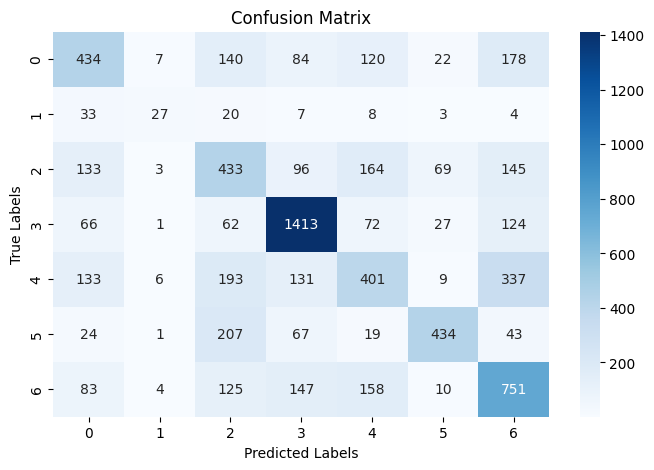

In [27]:
plt.figure(figsize=(8, 5))
sns.heatmap(m, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
raport = classification_report(y_true, y_pred_classes)
print(raport)

              precision    recall  f1-score   support

           0       0.48      0.44      0.46       985
           1       0.55      0.26      0.36       102
           2       0.37      0.42      0.39      1043
           3       0.73      0.80      0.76      1765
           4       0.43      0.33      0.37      1210
           5       0.76      0.55      0.63       795
           6       0.47      0.59      0.53      1278

    accuracy                           0.54      7178
   macro avg       0.54      0.48      0.50      7178
weighted avg       0.55      0.54      0.54      7178



drugi model

In [29]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [33]:
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
180/180 [==============================] - 81s 441ms/step - loss: 1.8172 - accuracy: 0.2465 - val_loss: 1.7767 - val_accuracy: 0.2623
Epoch 2/20
180/180 [==============================] - 77s 427ms/step - loss: 1.6712 - accuracy: 0.3289 - val_loss: 1.5172 - val_accuracy: 0.4060
Epoch 3/20
180/180 [==============================] - 77s 426ms/step - loss: 1.4620 - accuracy: 0.4318 - val_loss: 1.3958 - val_accuracy: 0.4641
Epoch 4/20
180/180 [==============================] - 77s 429ms/step - loss: 1.3412 - accuracy: 0.4860 - val_loss: 1.2909 - val_accuracy: 0.5045
Epoch 5/20
180/180 [==============================] - 77s 428ms/step - loss: 1.2537 - accuracy: 0.5193 - val_loss: 1.2438 - val_accuracy: 0.5233
Epoch 6/20
180/180 [==============================] - 77s 426ms/step - loss: 1.1857 - accuracy: 0.5521 - val_loss: 1.2135 - val_accuracy: 0.5352
Epoch 7/20
180/180 [==============================] - 82s 458ms/step - loss: 1.1263 - accuracy: 0.5729 - val_loss: 1.1910 - val_ac

podsumowanie modelu

In [34]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

m = confusion_matrix(y_true, y_pred_classes)

225/225 [==============================] - 7s 31ms/step


In [35]:
raport = classification_report(y_true, y_pred_classes)
print(raport)

              precision    recall  f1-score   support

           0       0.57      0.33      0.42       985
           1       0.52      0.29      0.38       102
           2       0.35      0.48      0.41      1043
           3       0.75      0.76      0.75      1765
           4       0.43      0.39      0.41      1210
           5       0.63      0.72      0.67       795
           6       0.52      0.55      0.54      1278

    accuracy                           0.55      7178
   macro avg       0.54      0.50      0.51      7178
weighted avg       0.56      0.55      0.55      7178



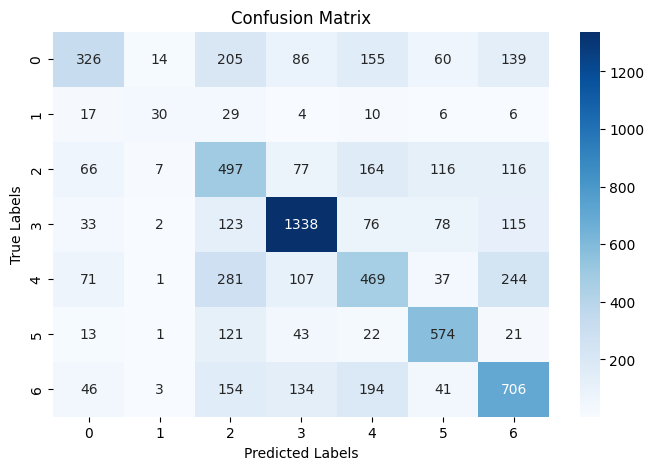

In [36]:
plt.figure(figsize=(8, 5))
sns.heatmap(m, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()